# Naive Risk Budgeting Strategies between PSP and GHP

We've already seen how we can compute the returns of a portfolio that mixes a PSP with a GHP. In this session we'll build some tools to put a more methodical structure around that process.

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit_128 as erk
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/johnmoses/Workstore/coursera-investment-management-specialization/C1-introduction-to-portfolio-construction-and-analysis-with-python/edhec_risk_kit_128.py:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if filetype is "returns":
/Users/johnmoses/Workstore/coursera-investment-management-specialization/C1-introduction-to-portfolio-construction-and-analysis-with-python/edhec_risk_kit_128.py:39: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "nfirms":
/Users/johnmoses/Workstore/coursera-investment-management-specialization/C1-introduction-to-portfolio-construction-and-analysis-with-python/edhec_risk_kit_128.py:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "size":


```python
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 should have the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights with a different shape than the returns")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix
```

## The Simplest Allocator - Fixed Mix

The allocator's job is to come up with a time series of weights, so let's create the simplest possible allocator - one that puts a fixed fraction in the first portfolio and the remaining in the second


```python
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data = w1, index=r1.index, columns=r1.columns)
```

We are now ready to rerun the experiment we ran last time ... a bond portfolio of 60% in the 10 year bond and 40% in the 30 year bond to generate a fixed mix bond portfolio.

In [2]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

/Users/johnmoses/Workstore/coursera-investment-management-specialization/C1-introduction-to-portfolio-construction-and-analysis-with-python/edhec_risk_kit_128.py:635: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4166666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  coupons.iloc[pay_date] = principal*coupon_rate/coupons_per_year
/Users/johnmoses/Workstore/coursera-investment-management-specialization/C1-introduction-to-portfolio-construction-and-analysis-with-python/edhec_risk_kit_128.py:635: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4166666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  coupons.iloc[pay_date] = principal*coupon_rate/coupons_per_year
/Users/johnmoses/Workstore/coursera-investment-management-spec

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035803,0.003354,0.583072,4.179334,-0.001539,-0.001153,1.683933,0.0


Next, we'll use this to create a 70-30 Stock Bond Mix. First, we'll generate stock returns:

In [3]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

And next, we'll use the mix backtester to build a 70-30 Stock-Bond mix. One way to assess the performance is, as before, to generate a composite and produce summary stats on the composite. We'll also examine a second approach, which is to compute summary stats on each scenario and average the summary stats.

In [4]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.058743,0.005139,0.10234,3.121233,-0.002386,-0.00178,5.444106,0.0


In [5]:
# Approach 2: compute stats on each scenario and then average
summaries = erk.summary_stats(rets_7030b)
summaries.mean()

Annualized Return          0.053294
Annualized Vol             0.107684
Skewness                   0.000397
Kurtosis                   2.928799
Cornish-Fisher VaR (5%)    0.046166
Historic CVaR (5%)         0.058241
Sharpe Ratio               0.211933
Max Drawdown              -0.211905
dtype: float64

However, both of these summaries are imperfect, since they aggregate across a wide distribution. In different situations one or the other might make sense, but for most individuals, the range of outcomes are what matters because we observe only one of the different possible scenarios.

Therefore, it make sense to example the range of possible outcomes and look at not just the average but also the less likely but possible outcomes.

## Distribution of Terminal Values and Measuring Risk Budget Efficiency

The basic idea is to measure the distribution of terminal values across all scenarios.

```python
def terminal_values(rets):
    """
    Computes the terminal values from a set of returns supplied as a T x N DataFrame
    Return a Series of length N indexed by the columns of rets
    """
    return (rets+1).prod()

def terminal_stats(rets, floor = 0.8, cap=np.inf, name="Stats"):
    """
    Produce Summary Statistics on the terminal values per invested dollar
    across a range of N scenarios
    rets is a T x N DataFrame of returns, where T is the time-step (we assume rets is sorted by time)
    Returns a 1 column DataFrame of Summary Stats indexed by the stat name 
    """
    terminal_wealth = (rets+1).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = breach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor-terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (cap-terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std" : terminal_wealth.std(),
        "p_breach": p_breach,
        "e_short":e_short,
        "p_reach": p_reach,
        "e_surplus": e_surplus
    }, orient="index", columns=[name])
    return sum_stats

```

In [6]:
pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30")],
          axis=1)

,FI,Eq,70/30
mean,1.382561,1.964512,1.774581
std,0.115429,1.021976,0.633459
p_breach,NaN,0.050000,0.012000
e_short,NaN,0.146724,0.121811
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


/var/folders/98/pgyvqp115_q7lctf5vvv65gr0000gp/T/ipykernel_5422/2155342496.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
/var/folders/98/pgyvqp115_q7lctf5vvv65gr0000gp/T/ipykernel_5422/2155342496.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750

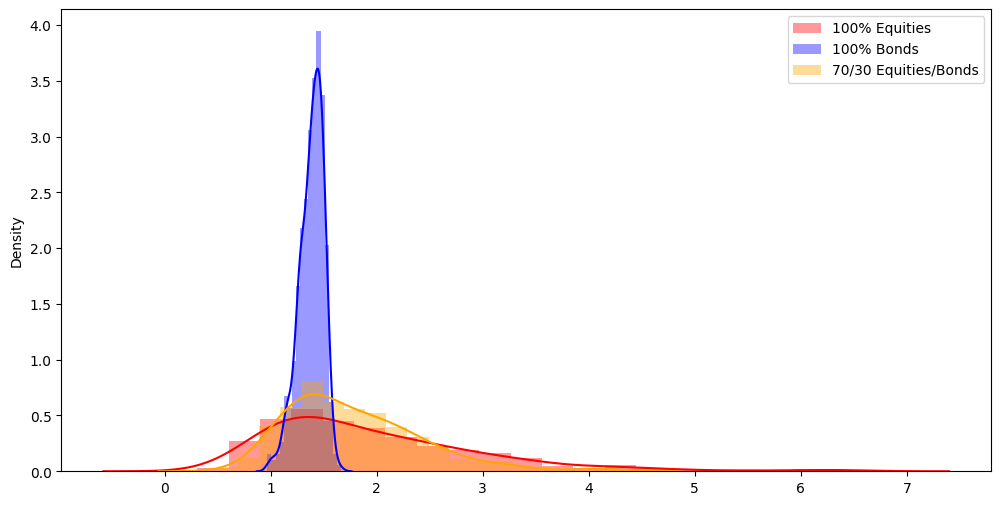

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend();

Note how the higher mean return of the equities portfolio is due in part to the large upside spread in equities.

## Risk Budgeting through Glide Path Allocation

A potential improvement over naive fixed mix is to risk budget by making a simplistic assumption that risk = time.

In other words, if you have more time, increase the risk budget. If you have less time, derisk. This is the thinking behind a Target Date Fund.

Let's write an allocator that defines the weights as a glidepath sthat starts at a starting weight and then gradually decreases the weights to equities over time to an ending weight. For example, you can start at 80% stocks at the start of the 10 year period and then gradually move to 20% stocks by the end of the 10 year period.

Let's see how this does:

```python
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0.0):
    """
    Allocates weights to r1 starting at start_glide and ends at end_glide
    by gradually moving from start_glide to end_glide over time
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths
```


In [8]:

rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.8, end_glide=.2)
pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30"),
           erk.terminal_stats(rets_g8020, name="Glide 80 to 20")],
          axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.382561,1.964512,1.774581,1.656644
std,0.115429,1.021976,0.633459,0.447207
p_breach,NaN,0.050000,0.012000,0.008000
e_short,NaN,0.146724,0.121811,0.075255
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


/var/folders/98/pgyvqp115_q7lctf5vvv65gr0000gp/T/ipykernel_5422/3826260911.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
/var/folders/98/pgyvqp115_q7lctf5vvv65gr0000gp/T/ipykernel_5422/3826260911.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed297

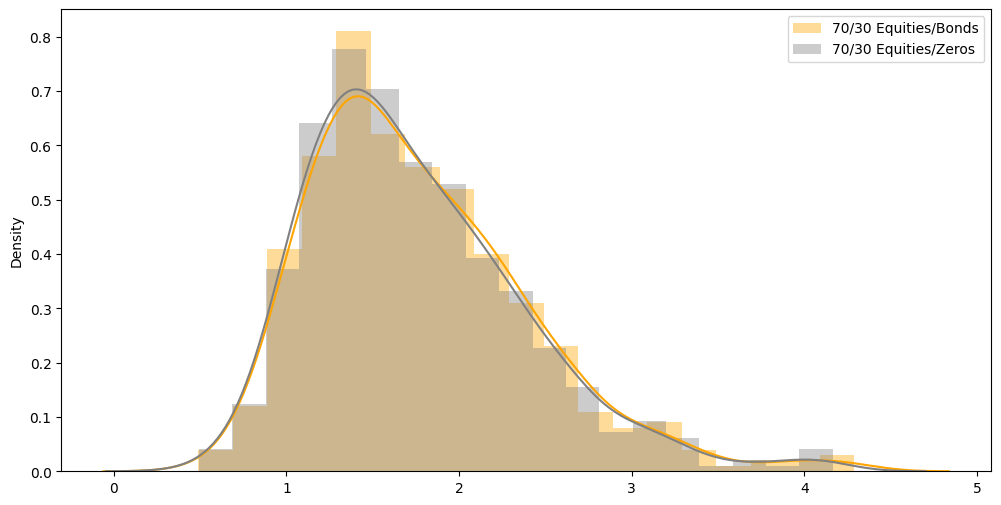

In [9]:
rets_7030z = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
plt.figure(figsize=(12, 6))
#sns.distplot(terminal_values(rets_eq), color="red", label="100% Equities")
#sns.distplot(terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
#sns.distplot(terminal_values(rets_g8020), color="green", label="Glide 80 to 20")
sns.distplot(erk.terminal_values(rets_7030z), color="grey", label="70/30 Equities/Zeros")
plt.legend();

### Conclusion

Static or Naive risk budgeting involves allocating between the PSP and GHP using either a simple fixed mix or a blind glidepath. These can reduce the downside risk but come at the cost the expected return, and cannot be used to secure a minimum acceptable level of wealth or liabilities. In the next session, we'll examine dynamic approaches that will address the challenge of meeting a set of future liabilities such as replacement income, or a required level of wealth in the future.

Before that, add the following code to the risk kit:

```python
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 should have the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights with a different shape than the returns")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix


def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data = w1, index=r1.index, columns=r1.columns)

def terminal_values(rets):
    """
    Computes the terminal values from a set of returns supplied as a T x N DataFrame
    Return a Series of length N indexed by the columns of rets
    """
    return (rets+1).prod()

def terminal_stats(rets, floor = 0.8, cap=np.inf, name="Stats"):
    """
    Produce Summary Statistics on the terminal values per invested dollar
    across a range of N scenarios
    rets is a T x N DataFrame of returns, where T is the time-step (we assume rets is sorted by time)
    Returns a 1 column DataFrame of Summary Stats indexed by the stat name 
    """
    terminal_wealth = (rets+1).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = breach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor-terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (cap-terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std" : terminal_wealth.std(),
        "p_breach": p_breach,
        "e_short":e_short,
        "p_reach": p_reach,
        "e_surplus": e_surplus
    }, orient="index", columns=[name])
    return sum_stats

def glidepath_allocator(r1, r2, start_glide=1, end_glide=0.0):
    """
    Allocates weights to r1 starting at start_glide and ends at end_glide
    by gradually moving from start_glide to end_glide over time
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

```
